In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm as tqdm
import pdb
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
path_to_data = 'Inputs-Targets.csv'

In [43]:
class WeatherDataset(Dataset):
    def __init__(self, csv_file, train=True):
        # Make 80/20 test training split without preserving order
        self.data = pd.read_csv(csv_file)
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        self.train = self.data.iloc[:int(len(self.data)*0.8)]
        self.test = self.data.iloc[int(len(self.data)*0.8):]
        if train:
            self.data = self.train 
        else:   
            self.data = self.test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # Return row as tensor
        x = torch.tensor(self.data.iloc[i][1:69])
        y = torch.tensor(self.data.iloc[i][69:72]).to(torch.float64)
        return x, y
        # return torch.tensor(self.data.iloc[i])

In [3]:
# Test dataset class

# t_data = WeatherDataset(path_to_data)
# t_dataloader = DataLoader(data, batch_size=4, shuffle=True)
# for batch in dataloader:
#     x, y = batch
#     print(x.dtype)
#     print(y.dtype)
#     break

torch.float64
torch.float64


In [44]:
resnet = models.resnet50(pretrained=True)

# Define trivial model
class WeatherModel(nn.Module):
    def __init__(self):
        super(WeatherModel, self).__init__()
        self.fc1 = nn.Linear(68, 256, dtype=torch.float64)
        self.fc2 = nn.Linear(256, 256, dtype=torch.float64)
        self.fc3 = nn.Linear(256, 256, dtype=torch.float64)
        self.fc4 = nn.Linear(512, 256, dtype=torch.float64)
        self.fcf = nn.Linear(256, 3, dtype=torch.float64)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x_prime = torch.relu(self.fc2(x))
        x = torch.relu(torch.cat([self.fc3(x_prime), x_prime], dim=1))
        x = torch.relu(self.fc4(x))
        return self.fcf(x)
    
class Res50Model(nn.Module):
    def __init__(self):
        super(Res50Model, self).__init__()
        self.input_layer = nn.Linear(68, 224 * 224 * 3, dtype=torch.float64)
        self.resnet = resnet.double()
        self.output_layer = nn.Linear(1000, 3, dtype=torch.float64)

    def forward(self, x):
        x = self.input_layer(x)
        x = x.view(-1, 3, 224, 224)
        x = self.resnet(x)
        x = self.output_layer(x)
        return x

In [45]:
BATCH_SIZE = 4
VALIDATE_EVERY = 200

# Make train and test datasets
train_data = WeatherDataset(path_to_data, train=True)
test_data = WeatherDataset(path_to_data, train=False)
# Initialize dataloaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [46]:
def cache_model(model, path='model.pt'):
    torch.save(model.state_dict(), path)

In [48]:
# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WeatherModel().to(device)
# model = Res50Model().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
losses = []
window_losses = []
val_losses = []

epochs_bar = tqdm(range(epochs), leave=False)

for epoch in range(epochs):
    batches_bar = tqdm(train_dataloader, leave=False)
    for batch in train_dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        batches_bar.update()

        # Update batch loop
        if batches_bar.n % VALIDATE_EVERY == 0:
            recent_avg_loss = sum(losses[-VALIDATE_EVERY:])/VALIDATE_EVERY
            window_losses.append(recent_avg_loss)
            batches_bar.set_description(f'Epoch {epoch+1}, Train Loss: {f"{recent_avg_loss:.3f}"}')
    # Validate every epoch
    val_batches_bar = tqdm(test_dataloader, leave=False)
    session_val_losses = []
    for batch in test_dataloader:
        model.eval()
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        session_val_losses.append(loss.item())
        val_batches_bar.update()
    val_losses.append(sum(session_val_losses)/len(session_val_losses))
    model.train()
    val_avg_loss = sum(val_losses[-len(test_dataloader):])/len(test_dataloader)
    epochs_bar.set_description(f'Epoch {epoch+1}, Train Loss: {f"{recent_avg_loss:.3f}"}, Val Loss: {f"{val_avg_loss:.3f}"}')

    epochs_bar.update()
    # Save model
    cache_model(model)

# Graph losses
plt.plot(losses)
plt.plot(val_losses)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10909 [00:00<?, ?it/s]

  0%|          | 0/2728 [00:00<?, ?it/s]

  0%|          | 0/10909 [00:00<?, ?it/s]

  0%|          | 0/2728 [00:00<?, ?it/s]

  0%|          | 0/10909 [00:00<?, ?it/s]

  0%|          | 0/2728 [00:00<?, ?it/s]

  0%|          | 0/10909 [00:00<?, ?it/s]

KeyboardInterrupt: 

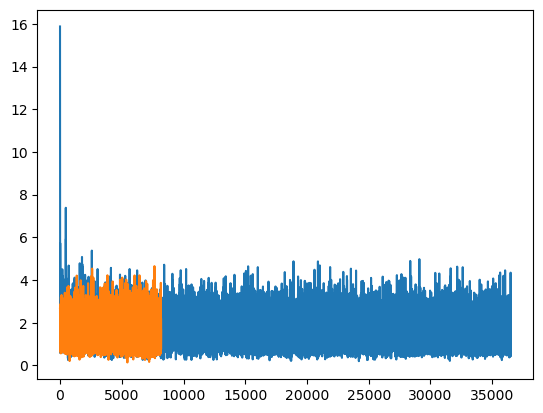

In [50]:
# Graph losses
plt.plot(losses)
plt.plot(val_losses)
plt.show()